# MLE for GPP and ER models in Nakano et al., 2022

(c) 2021 OKADA Teruhisa

- Estimate model parameters by MLE with AIC
- Variance is assumed unknown
- Observation  $ y_i \sim N(x_i, \sigma^2) $
- Model  $ x_i = f_i(\theta) = f_{Ti}(E) \cdot f_{PARi}(a, b, c) $

In [2]:
!python --version

import numpy as np
import scipy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

print('numpy', np.__version__)
print('scipy', scipy.__version__)
print('pandas', pd.__version__)
print('matplotlib', matplotlib.__version__)

Python 3.7.7
numpy 1.20.2
scipy 1.6.2
pandas 1.2.4
matplotlib 3.3.4


# Observation

- Daily GPP, ER, mean water temperature, and total PAR in data.csv

```csv
Date, GPP, ER, meanWT, totalPAR
2016/2/19, 1.76, -3.16, 4.27, 30.6
:
```

In [5]:
f = 'data.csv'

df = pd.read_csv(f, parse_dates=[0], index_col=0).sort_values('GPP')
df.ER *= -1

Nfree = df.shape[0]
print('Degree of freedom observation is', Nfree)

sigma_obs = df.GPP.std(ddof=1)
print(r'Initial observation error standard deviation set by GPP data:', sigma_obs)

Degree of freedom observation is 49
Initial observation error standard deviation set by GPP data: 8.327774945579263


# Model

$ R = f(T,I|R_{20}, E,a,b,c) = R_{20} \cdot \exp \left( \frac{E(T-T_{20})}{kTT_{20}} \right) \cdot (a I^2 + b I + c) $
- GPP: c=0
- ER: c=1

Text(0.5, 1.0, 'First guess')

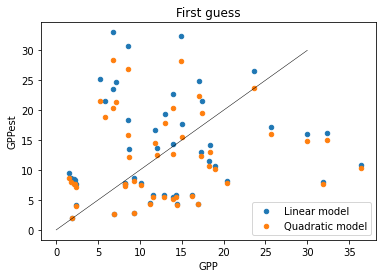

In [26]:
from scipy import optimize

class Model():
    """
    Base model
    """
    def __init__(self, data, T, I):
        self.data = data
        self.T = T
        self.I = I
        self.fi = None

    def ftemp(self, E):
        k = 8.62e-5
        T = self.T + 273. 
        T20 = 20. + 273.
        return np.exp(E * (T - T20) / (k * T * T20))
    
    def fi1(self, b, c):
        return b * self.I + c
        
    def fi2(self, a, b, c):
        return a * self.I ** 2 + b * self.I + c

    def estimate(self, xcoef):
        E, *param = xcoef
        return self.ftemp(E) * self.fi(*param)

class F1(Model):
    """
    Linear function with R20
    """
    def __init__(self, *args, c=0):
        Model.__init__(self, *args)
        self.fi = self.fi1
        self.pname = 'R20 E b'.split()
        self.c = c

    def estimate(self, xcoef):
        R20, E, b = xcoef
        return R20 * self.ftemp(E) * self.fi(b, self.c)

class F2(Model):
    """
    Quadratic function with R20
    """
    def __init__(self, *args, c=0):
        Model.__init__(self, *args)
        self.fi = self.fi2
        self.pname = 'R20 E a b'.split()
        self.c = c

    def estimate(self, xcoef):
        R20, E, a, b = xcoef
        return R20 * self.ftemp(E) * self.fi(a, b, self.c)
    
# set model
GPP1 = F1(df['GPP'], df['meanWT'], df['totalPAR'], c=0)
GPP2 = F2(df['GPP'], df['meanWT'], df['totalPAR'], c=0)
ER2  = F2(df['ER'],  df['meanWT'], df['totalPAR'], c=1)
    
# test (first guess)
x0 = [1., 0.4,         0.7]
est = GPP1.estimate(x0)
ax = df.assign(GPPest=est).plot.scatter(x='GPP', y='GPPest')

x0 = [1., 0.4, -0.002, 0.7]
GPPest0 = GPP2.estimate(x0)
ERest0 = ER2.estimate(x0)
df.assign(GPPest=GPPest0).plot.scatter(x='GPP', y='GPPest', ax=ax, c='C1')

ax.legend(['Linear model', 'Quadratic model'])
ax.plot([0,30],[0,30], lw=0.5, c='k')
ax.set_title('First guess')

# MLE (Maximum Likelihood Estimation)

- Log likelihood: $ \log L(\theta, \sigma^2) = −\frac{n}{2} \log(2 \pi) −\frac{n}{2} \log(\sigma^2) − \frac{1}{2 \sigma^2} \sum^n_{i=1} (f_i(\theta) − y_i)^2 $

- Standard Error (SE) calculated by Fisher information

- Model selection: $ \mathrm {AIC} =-2\log L+2k $

In [15]:
class MLE():
    """
    Maximum Likelihood Estimation
    """
    def __init__(self, model, x0, sigma):
        """    
        model: model class (object)
        x0: initial parameter values (array-like)
        sigma: initial sigma value (scaler)
        """
        self.model = model
        self.x0 = np.append(np.array(x0), sigma)  # estimate parameters

    def logL(self, x):
        xv = x * self.x0
        *xv, sigma = xv
        Hx = self.model.estimate(xv)
        y = self.model.data
        d = y - Hx
        n = d.shape[0]
        return -0.5*n * np.log(2*np.pi*sigma*sigma) -0.5/sigma/sigma * np.sum(d*d)
    
    def deviance(self, x):
        return -2 * self.logL(x)
    
    def optimize(self, disp=False):
        x0 = np.ones_like(self.x0)
        res = optimize.minimize(self.deviance, x0, method='BFGS', options={'disp':disp, 'maxiter':10000})
        res.x_scaled = res.x * self.x0
        res.se_scaled = np.sqrt(np.diag(res.hess_inv)) * np.abs(self.x0)
        return res

    def AIC(self, x):
        D = self.deviance(x)
        return D + 2*len(x)


def main(model, x0, sigma, plot=False, fout=None):
    """
    Main function
    Return: dict
    """
    mle = MLE(model, x0=x0, sigma=sigma)
    
    # optimize
    res = mle.optimize(disp=False)
    *x_opt, sigma_opt = res.x_scaled
    #print(res.x_scaled, res.message)
    print(res.message)
    
    # output
    x = res.x_scaled
    se = res.se_scaled
    out = {'k':len(res.x)}
    for i, pname in enumerate(model.pname):
        out[pname] = x[i]
        out[pname+'_se'] = se[i]
    out['sigma'] = x[-1]
    out['sigma_se'] = se[-1]
    out.update({
        'logL':mle.logL(res.x), 
        'deviance':mle.deviance(res.x), 
        'AIC':mle.AIC(res.x)
    })
    return out, x, se, res.message


def run_iter(model, x0, seed=0):
    np.random.seed(seed)
    out, xopt, se, m = main(model, x0=x0, sigma=sigma_obs)
    
    for i in range(1,10):
        if m == 'Optimization terminated successfully.' and i>1:
            return out
        x, xse = xopt[:-1]*(1/i), se[:-1]*(1/i)
        s, sse = xopt[-1]*(1/i), se[-1]*(1/i)
        out, xopt, se, m = main(model, x0=np.random.normal(x, xse), sigma=np.random.normal(s, sse))


# test
x0 = [10., 0.1, -0.001, 10.]
GPPopt = run_iter(GPP2, x0, seed=0)

Desired error not necessarily achieved due to precision loss.
Desired error not necessarily achieved due to precision loss.
Optimization terminated successfully.


# Estimate GPP

Optimization terminated successfully.
Desired error not necessarily achieved due to precision loss.
Optimization terminated successfully.


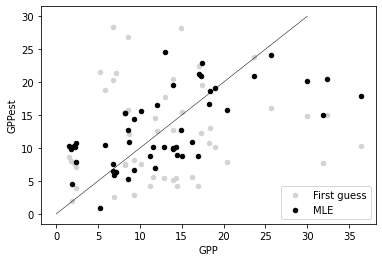

In [31]:
GPPopt = run_iter(GPP2, x0, seed=0)

est = GPP2.estimate([GPPopt[vname] for vname in 'R20 E a b'.split()])
ax = df.assign(GPPest=GPPest0).plot.scatter(x='GPP', y='GPPest', c='lightgrey')
ax = df.assign(GPPest=est).plot.scatter(x='GPP', y='GPPest', c='k', ax=ax)
ax.legend(['First guess', 'MLE'])
ax.plot([0,30],[0,30], lw=0.5, c='k')

# Estimate ER

Desired error not necessarily achieved due to precision loss.
Optimization terminated successfully.


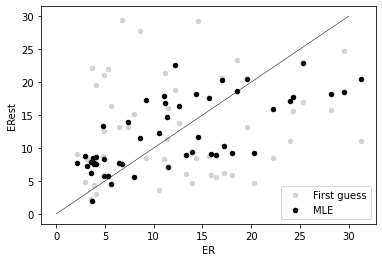

In [30]:
ERopt = run_iter(ER2, x0, seed=0)

est = ER2.estimate([ERopt[vname] for vname in 'R20 E a b'.split()])
ax = df.assign(ERest=ERest0).plot.scatter(x='ER', y='ERest', c='lightgrey')
ax = df.assign(ERest=est).plot.scatter(x='ER', y='ERest', c='k', ax=ax)
ax.legend(['First guess', 'MLE'])
ax.plot([0,30],[0,30], lw=0.5, c='k')

# Export CSV file

In [60]:
f = 'MLE.csv'

raw = pd.DataFrame([GPPopt, ERopt], index='GPP ER'.split())
raw = raw[GPPopt.keys()]
raw.to_csv(f'raw_{f}')

with open(f, 'w', encoding='utf-8') as f:
    f.write(' , k, b0, E, a, b, sigma, logL, Deviance, AIC\n')
    for i, row in raw.iterrows():
        f.write('{}, {:.0f}, {:.2f}±{:.2f}, {:.3f}±{:.3f}, {:.4f}±{:.4f}, {:.3f}±{:.3f}, {:.2f}±{:.2f}, {:.1f}, {:.1f}, {:.1f}\n'.format(i, *row))